# Initial Data Exploration

This notebook is used to carry out some exploratory analysis on a dataset of games available on Steam.

We start by loading and combining the data.

In [24]:
import pandas as pd
import numpy as np

all_games = pd.read_csv("../data/external/all_titles_20240617.csv", index_col="appid")
game_dates = pd.read_csv("../data/external/game_dates.csv", index_col="appid").drop_duplicates()
game_tags = pd.read_csv("../data/external/game_tags.csv", index_col="appid").drop_duplicates()

# Clear up unnecessary columns formed from indexes in data pulling
for df in [all_games, game_dates, game_tags]:
    df.drop(columns="Unnamed: 0", inplace=True)

# Combine data into single dataset
games = all_games.merge(game_dates, left_index=True, right_index=True)
games = games.merge(game_tags, left_index=True, right_index=True)
games.head(10)

,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,...,initialprice,discount,ccu,date,genre,tag1,tag2,tag3,tag4,tag5
appid,,,,,,,,,,,,,,,,,,,,,
10,Counter-Strike,Valve,Valve,NaN,231572,6056,0,"10,000,000 .. 20,000,000",10838,574,...,999.0,0.0,12717,"1 Nov, 2000",Action,Action,FPS,Multiplayer,Shooter,Classic
20,Team Fortress Classic,Valve,Valve,NaN,7126,1086,0,"5,000,000 .. 10,000,000",245,0,...,499.0,0.0,70,"1 Apr, 1999",Action,Action,FPS,Multiplayer,Classic,Hero Shooter
30,Day of Defeat,Valve,Valve,NaN,6133,668,0,"5,000,000 .. 10,000,000",236,6,...,499.0,0.0,69,"1 May, 2003",Action,FPS,World War II,Multiplayer,Shooter,Action
40,Deathmatch Classic,Valve,Valve,NaN,2454,517,0,"5,000,000 .. 10,000,000",48,1,...,499.0,0.0,6,"1 Jun, 2001",Action,Action,FPS,Classic,Multiplayer,Shooter
50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,21210,1078,0,"2,000,000 .. 5,000,000",346,0,...,499.0,0.0,118,"1 Nov, 1999",Action,FPS,Action,Classic,Sci-fi,Singleplayer
60,Ricochet,Valve,Valve,NaN,4661,1006,0,"5,000,000 .. 10,000,000",32,0,...,499.0,0.0,5,"1 Nov, 2000",Action,Action,FPS,Multiplayer,Classic,First-Person
70,Half-Life,Valve,Valve,NaN,123432,4416,0,"10,000,000 .. 20,000,000",706,64,...,999.0,0.0,1047,"8 Nov, 1998",Action,FPS,Classic,Singleplayer,1990's,Multiplayer
80,Counter-Strike: Condition Zero,Valve,Valve,NaN,22806,2169,0,"5,000,000 .. 10,000,000",1617,11,...,999.0,0.0,377,"1 Mar, 2004",Action,Action,FPS,Shooter,Multiplayer,First-Person
130,Half-Life: Blue Shift,Gearbox Software,Valve,NaN,15055,1291,0,"2,000,000 .. 5,000,000",154,0,...,499.0,0.0,64,"1 Jun, 2001",Action,FPS,Action,Sci-fi,Singleplayer,Shooter


We have various data on games, including basic metadata (name, publisher, release date, genres and tags), number of owners in a range, and usage stats (average/median playtime, peak users yesterday - ccu).

Let's look at the data types:

In [22]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33612 entries, 10 to 3002860
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             33610 non-null  object 
 1   developer        33507 non-null  object 
 2   publisher        33571 non-null  object 
 3   score_rank       11 non-null     float64
 4   positive         33612 non-null  int64  
 5   negative         33612 non-null  int64  
 6   userscore        33612 non-null  int64  
 7   owners           33612 non-null  object 
 8   average_forever  33612 non-null  int64  
 9   average_2weeks   33612 non-null  int64  
 10  median_forever   33612 non-null  int64  
 11  median_2weeks    33612 non-null  int64  
 12  price            33612 non-null  float64
 13  initialprice     33612 non-null  float64
 14  discount         33612 non-null  float64
 15  ccu              33612 non-null  int64  
 16  date             33575 non-null  object 
 17  genre         

A couple of variables will need converting to more useful formats - the date and the owners.

In [27]:
# Convert date to datetime data type
games['date'] = pd.to_datetime(games['date'], errors="coerce")

In [56]:
#Convert owners to ordered category data type
from pandas.api.types import CategoricalDtype

labels = games['owners'].unique()
categories = sorted(labels, key=lambda x: int(x.split(" .. ")[0].replace(",","")))

cat_type = CategoricalDtype(categories=categories, ordered=True)
games['owners'] = games['owners'].astype(cat_type)

appid
10         10,000,000 .. 20,000,000
20          5,000,000 .. 10,000,000
30          5,000,000 .. 10,000,000
40          5,000,000 .. 10,000,000
50           2,000,000 .. 5,000,000
                     ...           
2965660            20,000 .. 50,000
2974190            20,000 .. 50,000
2979110                 0 .. 20,000
2988090           50,000 .. 100,000
3002860                 0 .. 20,000
Name: owners, Length: 33612, dtype: category
Categories (14, object): ['0 .. 20,000' < '20,000 .. 50,000' < '50,000 .. 100,000' < '100,000 .. 200,000' ... '20,000,000 .. 50,000,000' < '50,000,000 .. 100,000,000' < '100,000,000 .. 200,000,000' < '200,000,000 .. 500,000,000']

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


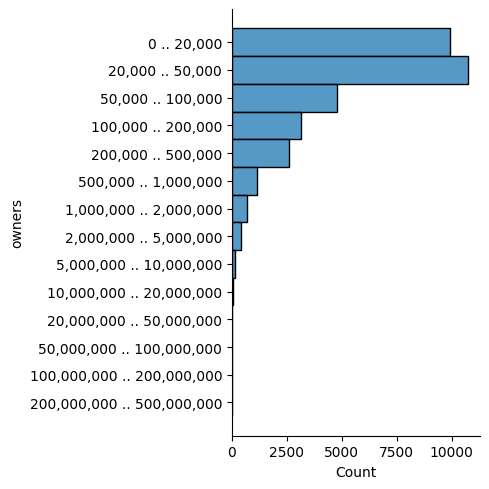

In [62]:
import seaborn as sns

_ = sns.displot(
    data=games,
    y="owners"
)

In [65]:
games['tag1'].value_counts().head(20)

tag1
Action              4374
Adventure           3157
Casual              2580
Indie               2533
Strategy            2024
Free to Play        1930
RPG                 1673
Early Access        1306
Simulation          1151
Horror               666
Racing               464
Puzzle               457
Visual Novel         397
Exploration          338
Action Roguelike     325
Sexual Content       323
Sports               297
FPS                  266
VR                   224
Anime                170
Name: count, dtype: int64